# Each section can be run on its own

# GBIF

In [3]:
from pygbif import species as species
from pygbif import occurrences as occ

In [4]:
splist = ['Cyanocitta stelleri', 'Junco hyemalis', 'Aix sponsa',
  'Ursus americanus', 'Pinus conorta', 'Poa annuus']
keys = [ species.name_backbone(x)['usageKey'] for x in splist ]

In [5]:
out = [ occ.search(taxonKey = x, limit=0)['count'] for x in keys ]

In [6]:
x = dict(zip(splist, out))
sorted(x.items(), key=lambda z:z[1], reverse=True)

[('Junco hyemalis', 14827936),
 ('Aix sponsa', 6498428),
 ('Cyanocitta stelleri', 2756192),
 ('Poa annuus', 741730),
 ('Pinus conorta', 105934),
 ('Ursus americanus', 53946)]

# SatCLIP

In [7]:
import sys
import os

In [11]:
# clone satclip into a folder, use your own username
satclip_path = "/home/mila/g/<username>/scratch/satclip"

In [12]:
sys.path.append(satclip_path)
sys.path.insert(0, "/home/mila/g/<username>/scratch/satclip/satclip")

In [13]:
from satclip.model import SatCLIP

/network/scratch/g/gregory.bell/COMP-685-Fall-2025/.venv/lib/python3.11/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


In [14]:
from satclip.location_encoder import LocationEncoder

In [15]:
model = SatCLIP(
    embed_dim=512,
    image_resolution=224, in_channels=13, vision_layers=4, vision_width=768, vision_patch_size=32, # Image encoder
    le_type='sphericalharmonics', pe_type='siren', legendre_polys=10, frequency_num=16, max_radius=360, min_radius=1, harmonics_calculation='analytic'  # Location encoder
)


using vision transformer


In [16]:
import torch

In [17]:
img_batch = torch.randn(32, 13, 224, 224) # Represents a batch of 32 images
loc_batch = torch.randn(32, 2) # Represents the corresponding 32 locations (lon/lat)

In [18]:
with torch.no_grad():
    logits_per_image, logits_per_coord = model(img_batch, loc_batch)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()

# INaturalist

In [19]:
from pyinaturalist import get_observations

In [20]:
observations = get_observations()

INFO:Request:
GET https://api.inaturalist.org/v1/observations
User-Agent: python-requests/2.32.5 pyinaturalist/0.20.2
Accept-Encoding: gzip, deflate
Accept: application/json
Connection: keep-alive



In [21]:
observations.keys()

dict_keys(['total_results', 'page', 'per_page', 'results'])

In [22]:
observations['total_results']

312784440

# eBird

In [1]:
# account api key is needed, may be best to load dataset outside computer node.

# TimesFM

In [1]:
# clone in another folder and install in the uv venv

In [1]:
# pip install transformers>=4.53 torch numpy
import numpy as np
import torch
from torch.nn.functional import normalize
from transformers import TimesFmModelForPrediction

# 1) Load a TimesFM checkpoint (univariate)
model = TimesFmModelForPrediction.from_pretrained(
    "google/timesfm-2.0-500m-pytorch",  # or a newer 2.5 checkpoint if/when available
    dtype=torch.bfloat16,
    attn_implementation="sdpa",
    device_map="auto",
)

# 2) Example batch of variable-length time series (replace with your data)
series = [
    np.sin(np.linspace(0, 20, 100)),   # length 100
    np.sin(np.linspace(0, 20, 240)),   # length 240
    np.sin(np.linspace(0, 20, 512)),   # length 512
    np.sin(np.linspace(0, 20, 1024)),   # length 1024
]

# Convert to tensors on the model's device
past_values = [torch.tensor(x, dtype=torch.bfloat16, device=model.device) for x in series]

# TimesFM uses a small frequency embedding; if you don't know it, you can set zeros.
# Shape: (batch,)
freq = torch.zeros(len(past_values), dtype=torch.long, device=model.device)

# 3) Forward pass requesting hidden states
with torch.no_grad():
    out = model(
        past_values=past_values,
        freq=freq,
        output_hidden_states=True,   # <— important
        return_dict=True,
    )

# out.last_hidden_state: (batch, seq_len, hidden_size) after internal padding
# We'll mean-pool over the *valid* timesteps for each series, then L2-normalize.

embeddings = []
for i, ts in enumerate(past_values):
    L = ts.shape[0]  # original (unpadded) length
    # slice to valid region, mean-pool over time
    vec = out.last_hidden_state[i, :L, :].float().mean(dim=0)
    embeddings.append(vec)

embeddings = torch.stack(embeddings, dim=0)           # (batch, hidden_size)
embeddings = normalize(embeddings, p=2, dim=1)        # cosine-friendly

print(embeddings.shape)   # e.g., torch.Size([4, 1280]) for the 500M checkpoint

/network/scratch/g/gregory.bell/COMP-685-Fall-2025/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([4, 1280])


# Chronos

In [2]:

import numpy as np
import torch
from torch.nn.functional import normalize
from chronos import ChronosPipeline

# 1) Load a Chronos (T5) checkpoint
pipe = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",           # try base/large for bigger models
    device_map="auto",
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
)

# 2) Example batch: variable-length univariate series
rng = np.random.default_rng(0)
series = [
    np.sin(np.linspace(0, 8*np.pi, 120)) + 0.1 * rng.standard_normal(120),
    np.sin(np.linspace(0, 8*np.pi, 200)) + 0.1 * rng.standard_normal(200),
    np.sin(np.linspace(0, 8*np.pi, 350)) + 0.1 * rng.standard_normal(350),
]

# Convert to a list of 1D tensors (no manual padding needed)
batch = [torch.tensor(x, dtype=torch.float32) for x in series]
lengths = [len(x) for x in batch]

# 3) Extract encoder embeddings for the whole batch
#    emb has shape (batch, seq_len, hidden) with internal padding handled for you.
emb, tok_state = pipe.embed(batch)

# 4) Pool to a single fixed-size vector per series (mask out padding)
#    We'll mean-pool over the valid (unpadded) timesteps, then L2-normalize.
pooled = []
for i, L in enumerate(lengths):
    vec = emb[i, :L, :].float().mean(dim=0)   # (hidden,)
    pooled.append(vec)

embeddings = torch.stack(pooled, dim=0)       # (batch, hidden)
embeddings = normalize(embeddings, p=2, dim=1)

print("Per-series embedding shape:", embeddings.shape)   # e.g., torch.Size([3, hidden])


`torch_dtype` is deprecated! Use `dtype` instead!


Per-series embedding shape: torch.Size([3, 512])


# Crop yield yearly data

Iizumi, Toshichika (2019): Global dataset of historical yields v1.2 and v1.3 aligned version [dataset]. PANGAEA, https://doi.org/10.1594/PANGAEA.909132,
Supplement to: Iizumi, Toshichika; Sakai, T (2020): The global dataset of historical yields for major crops 1981–2016. Scientific Data, 7(1), 97, https://doi.org/10.1038/s41597-020-0433-7

https://doi.pangaea.de/10.1594/PANGAEA.909132

In [12]:
!wget https://store.pangaea.de/Publications/IizumiT_2019/gdhy_v1.2_v1.3_20190128.zip

--2025-11-16 17:28:24--  https://store.pangaea.de/Publications/IizumiT_2019/gdhy_v1.2_v1.3_20190128.zip
Resolving store.pangaea.de (store.pangaea.de)... 134.1.2.172
Connecting to store.pangaea.de (store.pangaea.de)|134.1.2.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15989683 (15M) [application/zip]
Saving to: ‘gdhy_v1.2_v1.3_20190128.zip’

gdhy_v1.2_v1.3_2019 100%[===================>]  15.25M  10.9MB/s    in 1.4s    

2025-11-16 17:28:26 (10.9 MB/s) - ‘gdhy_v1.2_v1.3_20190128.zip’ saved [15989683/15989683]



In [13]:
!mv gdhy_v1.2_v1.3_20190128.zip data/gdhy_v1.2_v1.3_20190128.zip

In [14]:
!unzip -q data/gdhy_v1.2_v1.3_20190128.zip -d data/

In [38]:
import xarray as xr
import pandas as pd 
from datetime import datetime

In [46]:
# each file is a year
crops = ['wheat', 'soybean', 'rice', 'maize']
years = list(range(1981, 2017))
dfs = {}
for crop in crops:
    for year in years:
        dataset = xr.open_dataset(f'data/{crop}/yield_{year}.nc4')
        df = dataset.to_dataframe().reset_index()
        df['year'] =  datetime(year, 12, 31)
        # change to >-180 to 180 instead of >0 to 360 longitude
        df['lon'] = [i if i <= 180 else -360 + i for i in df['lon']]
        dfs[f"{crop}_{year}"] = df

In [47]:
df = pd.concat([i for i in dfs.values()])

In [49]:
df

,lat,lon,var,year
0,-89.75,0.25,NaN,1981-12-31
1,-89.75,0.75,NaN,1981-12-31
2,-89.75,1.25,NaN,1981-12-31
3,-89.75,1.75,NaN,1981-12-31
4,-89.75,2.25,NaN,1981-12-31
...,...,...,...,...
259195,89.75,-2.25,NaN,2016-12-31
259196,89.75,-1.75,NaN,2016-12-31
259197,89.75,-1.25,NaN,2016-12-31
259198,89.75,-0.75,NaN,2016-12-31


In [50]:
df[df['year']==datetime(2016, 12, 31)]

,lat,lon,var,year
0,-89.75,0.25,NaN,2016-12-31
1,-89.75,0.75,NaN,2016-12-31
2,-89.75,1.25,NaN,2016-12-31
3,-89.75,1.75,NaN,2016-12-31
4,-89.75,2.25,NaN,2016-12-31
...,...,...,...,...
259195,89.75,-2.25,NaN,2016-12-31
259196,89.75,-1.75,NaN,2016-12-31
259197,89.75,-1.25,NaN,2016-12-31
259198,89.75,-0.75,NaN,2016-12-31


/tmp/ipykernel_2866157/1470416620.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Figure size 640x480 with 0 Axes>

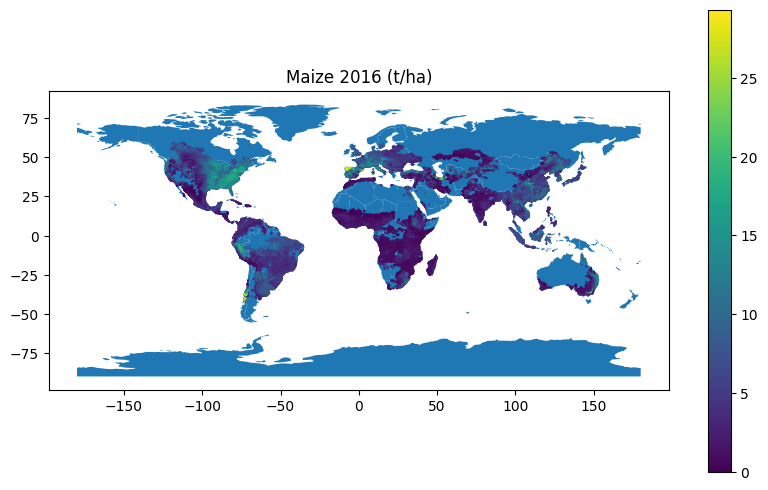

In [52]:
import matplotlib.pyplot as plt
import geopandas as gpd

plt.figure()
gdf = gpd.GeoDataFrame(df[df['year']==datetime(2016, 12, 31)], geometry=gpd.points_from_xy(df[df['year']==datetime(2016, 12, 31)]['lon'], df[df['year']==datetime(2016, 12, 31)]['lat']))   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

gdf.plot(ax=world.plot(figsize=(10, 6)), column=df[df['year']==datetime(2016, 12, 31)]['var'], markersize=0.2, legend=True)
plt.title(f"Maize 2016 (t/ha)")
plt.show()

# OpenAQ

https://www.kaggle.com/datasets/open-aq/openaq/data

In [81]:
import pandas as pd
from datetime import datetime
df = pd.read_csv("openaq.csv").drop(columns='Unnamed: 0')

In [90]:
datetime.fromisoformat('2022-05-04 04:00:00+00:00')

datetime.datetime(2022, 5, 4, 4, 0, tzinfo=datetime.timezone.utc)

In [91]:

df['date'] = df.timestamp.apply(datetime.fromisoformat)

In [96]:
df.date.dt.date.min(), df.date.dt.date.max()

(datetime.date(2007, 2, 9), datetime.date(2022, 5, 26))

In [97]:
df.head()

,latitude,longitude,timestamp,value,pollutant,date
0,1.0,50.836389,2022-05-04 04:00:00+00:00,1.81098,bc,2022-05-04 04:00:00+00:00
1,1.0,50.768729,2022-05-10 01:00:00+00:00,2.18117,bc,2022-05-10 01:00:00+00:00
2,1.0,51.050611,2022-05-06 19:00:00+00:00,0.30000,bc,2022-05-06 19:00:00+00:00
3,1.0,50.299128,2022-04-28 21:00:00+00:00,2.33010,bc,2022-04-28 21:00:00+00:00
4,1.0,54.193986,2022-05-03 03:00:00+00:00,0.27270,bc,2022-05-03 03:00:00+00:00


In [122]:
df[(df['date'].dt.year == 2020)]

,latitude,longitude,timestamp,value,pollutant,date
1132,42.62557,20.896210,2020-06-10 15:00:00+00:00,75.0,co,2020-06-10 15:00:00+00:00
1149,1.00000,29.983400,2020-12-31 16:00:00+00:00,600.0,co,2020-12-31 16:00:00+00:00
1168,1.00000,23.416800,2020-12-31 16:00:00+00:00,1000.0,co,2020-12-31 16:00:00+00:00
1234,1.00000,37.798300,2020-06-25 15:00:00+00:00,900.0,co,2020-06-25 15:00:00+00:00
1273,1.00000,50.248600,2020-12-31 16:00:00+00:00,300.0,co,2020-12-31 16:00:00+00:00
...,...,...,...,...,...,...
5589613,47.83861,-120.023060,2020-06-11 00:00:00+00:00,2.2,pm25,2020-06-11 00:00:00+00:00
5591209,34.06643,-118.226750,2020-06-10 23:00:00+00:00,6.0,pm25,2020-06-10 23:00:00+00:00
5591666,1.00000,47.198124,2020-09-29 22:00:00+00:00,0.0,pm25,2020-09-29 22:00:00+00:00
5592129,33.73970,-81.853600,2020-06-11 00:00:00+00:00,9.0,pm25,2020-06-11 00:00:00+00:00


/tmp/ipykernel_2866157/1460853482.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Figure size 640x480 with 0 Axes>

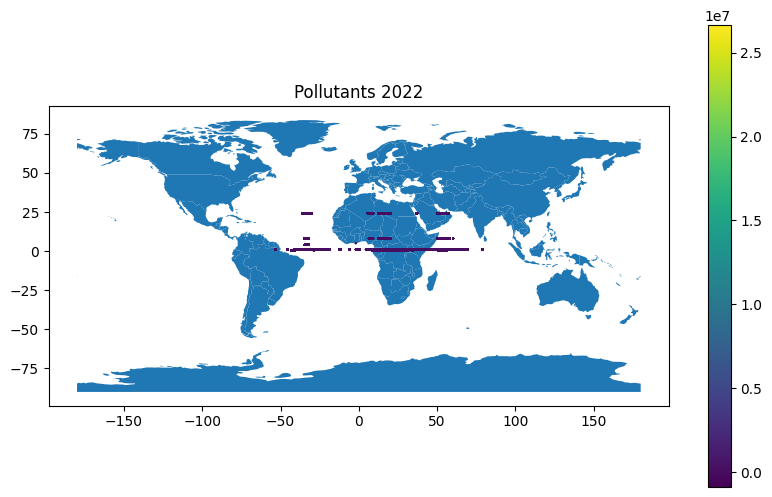

In [124]:
import matplotlib.pyplot as plt
import geopandas as gpd
year = 2022
plt.figure()
gdf = gpd.GeoDataFrame(df[(df['date'].dt.year == year)], geometry=gpd.points_from_xy(df[(df['date'].dt.year == year)]['longitude'], df[(df['date'].dt.year == year)]['latitude']))   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

gdf.plot(ax=world.plot(figsize=(10, 6)), column=df[(df['date'].dt.year == year)]['value'], markersize=0.2, legend=True)
plt.title(f"Pollutants {year}")
plt.show()

In [130]:
df_no_lat1 = df[df['latitude'] != 1]

In [206]:
df_no_neg_val = df_no_lat1[df_no_lat1['value'] >= 0]

In [207]:
df_clean = df_no_neg_val[round(df_no_neg_val['latitude']) != df_no_neg_val['latitude']]

In [208]:
df_clean = df_clean[df_clean['latitude'] != 0.25]

In [209]:
df_clean

,latitude,longitude,timestamp,value,pollutant,date
1132,42.625570,20.896210,2020-06-10 15:00:00+00:00,75.0,co,2020-06-10 15:00:00+00:00
1208,55.994040,37.172142,2017-09-11 08:00:00+00:00,370.0,co,2017-09-11 08:00:00+00:00
1283,45.800340,15.974072,2020-06-10 22:00:00+00:00,0.0,co,2020-06-10 22:00:00+00:00
1371,41.251120,29.038280,2018-06-21 13:00:00+00:00,270.0,co,2018-06-21 13:00:00+00:00
1387,55.990154,37.227837,2017-09-11 08:00:00+00:00,270.0,co,2017-09-11 08:00:00+00:00
...,...,...,...,...,...,...
5589613,47.838610,-120.023060,2020-06-11 00:00:00+00:00,2.2,pm25,2020-06-11 00:00:00+00:00
5591209,34.066430,-118.226750,2020-06-10 23:00:00+00:00,6.0,pm25,2020-06-10 23:00:00+00:00
5592129,33.739700,-81.853600,2020-06-11 00:00:00+00:00,9.0,pm25,2020-06-11 00:00:00+00:00
5593345,33.410500,-111.865100,2020-06-11 00:00:00+00:00,0.8,pm25,2020-06-11 00:00:00+00:00


In [210]:
df_clean.date.dt.date.min(), df_clean.date.dt.date.max()

(datetime.date(2007, 2, 9), datetime.date(2020, 6, 11))

In [211]:
df_clean.pollutant.unique()

array(['co', 'o3', 'no2', 'so2', 'pm10', 'bc', 'pm25'], dtype=object)

/tmp/ipykernel_2866157/281422838.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Figure size 640x480 with 0 Axes>

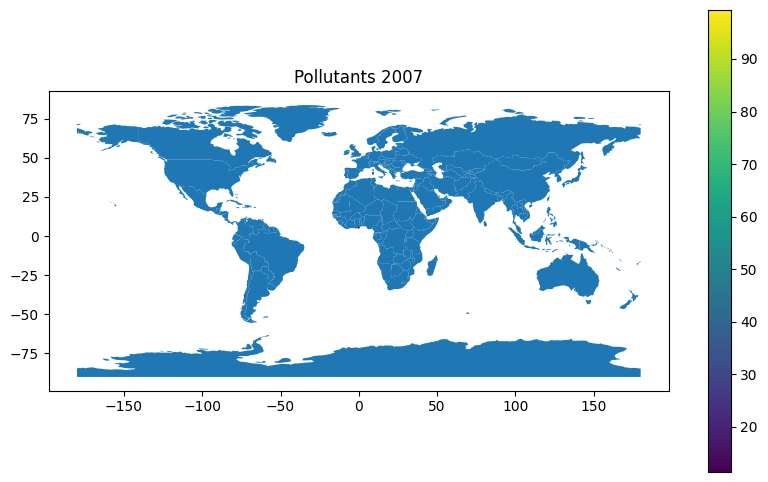

In [212]:
import matplotlib.pyplot as plt
import geopandas as gpd
year = 2007
plt.figure()
gdf = gpd.GeoDataFrame(df_clean[(df_clean['date'].dt.year == year)], geometry=gpd.points_from_xy(df_clean[(df_clean['date'].dt.year == year)]['longitude'], df_clean[(df_clean['date'].dt.year == year)]['latitude']))   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

gdf.plot(ax=world.plot(figsize=(10, 6)), column=df_clean[(df_clean['date'].dt.year == year)]['value'], markersize=0.2, legend=True)
plt.title(f"Pollutants {year}")
plt.show()

/tmp/ipykernel_2866157/3507469959.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Figure size 640x480 with 0 Axes>

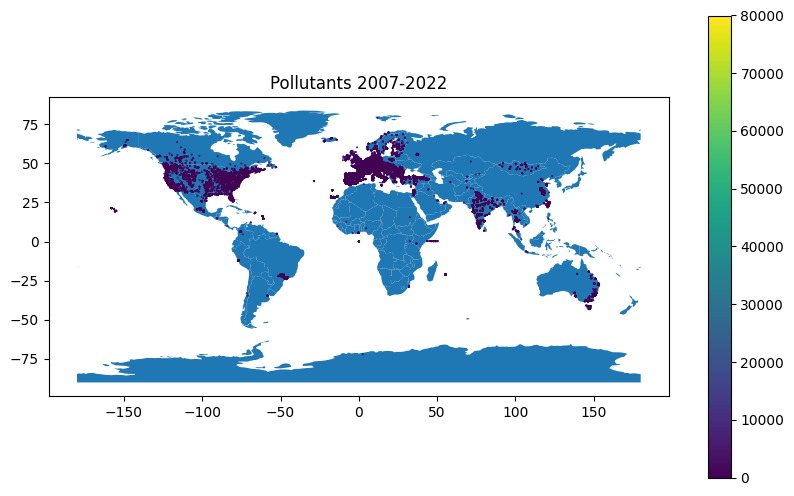

In [213]:
import matplotlib.pyplot as plt
import geopandas as gpd

plt.figure()
gdf = gpd.GeoDataFrame(df_clean, geometry=gpd.points_from_xy(df_clean['longitude'], df_clean['latitude']))   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

gdf.plot(ax=world.plot(figsize=(10, 6)), column=df_clean['value'], markersize=0.2, legend=True)
plt.title(f"Pollutants 2007-2022")
plt.show()

In [214]:
df_clean.to_csv("openaq_clean.csv")

# UFOs!

https://corgis-edu.github.io/corgis/csv/ufo_sightings/

In [165]:
import pandas as pd

In [175]:
df_ufo = pd.read_csv('ufo_sightings.csv')

In [177]:
df_ufo ['date'] = pd.to_datetime(df_ufo['Dates.Sighted.Year'].astype(str) + '/' + df_ufo['Dates.Sighted.Month'].astype(str) + '/' + df_ufo['Date.Sighted.Day'].astype(str))

In [203]:
df_ufo

,Location.City,Location.State,Location.Country,Data.Shape,Data.Encounter duration,Data.Description excerpt,Location.Coordinates.Latitude,Location.Coordinates.Longitude,Dates.Sighted.Year,Dates.Sighted.Month,Date.Sighted.Day,Dates.Sighted.Hour,Dates.Sighted.Minute,Dates.Documented.Year,Dates.Documented.Month,Dates.Documented.Day,date
0,anchor point,AK,US,disk,300.0,Large UFO over Mt. ILIAMNA Alaska. ((NUFORC N...,59.776667,-151.831389,2005,5,24,18,30,2005,5,28,2005-05-24
1,anchorage,AK,US,changing,21600.0,We could observe red lights dancing across the...,61.218056,-149.900278,2000,12,31,21,0,2001,2,18,2000-12-31
2,anchorage,AK,US,changing,600.0,INTENSE AMBER-ORANGE HONEYCOMB SHAPED DUAL HOR...,61.218056,-149.900278,2006,10,23,21,3,2006,12,7,2006-10-23
3,anchorage,AK,US,cigar,15.0,I explained away the first time I thought I se...,61.218056,-149.900278,2014,3,29,20,45,2014,4,4,2014-03-29
4,anchorage,AK,US,circle,300.0,Orange circles &quot;climbing&quot; then fadin...,61.218056,-149.900278,2011,10,21,21,0,2011,10,25,2011-10-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60627,sheridan,WY,US,oval,20.0,blue-green bright oval was spotted 20 miles so...,44.797222,-106.955556,2002,9,6,21,0,2002,9,13,2002-09-06
60628,thermopolis,WY,US,unknown,15.0,UFO near Thermopolis WY,43.646111,-108.211389,2007,6,14,23,0,2007,8,7,2007-06-14
60629,torrington,WY,US,cigar,2.0,I was on a hill enjoying the sunset. I fell as...,42.065000,-104.181111,2011,11,5,21,30,2011,12,12,2011-11-05
60630,worland,WY,US,light,15.0,The object was a dim point of light that grew ...,44.016944,-107.954722,2003,6,17,22,42,2003,6,18,2003-06-17


In [204]:
df_ufo['Location.Country'].unique()

array(['US'], dtype=object)

/tmp/ipykernel_2866157/1195109102.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Figure size 640x480 with 0 Axes>

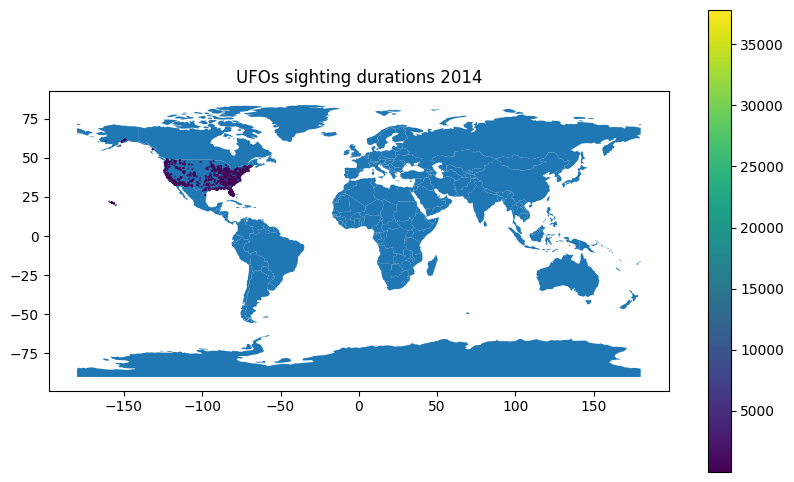

In [205]:
import matplotlib.pyplot as plt
import geopandas as gpd
year = 2014
plt.figure()
gdf = gpd.GeoDataFrame(df_ufo[(df_ufo['date'].dt.year == year)], geometry=gpd.points_from_xy(df_ufo[df_ufo['date'].dt.year == year]['Location.Coordinates.Longitude '], df_ufo[(df_ufo['date'].dt.year == year)]['Location.Coordinates.Latitude ']))   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

gdf.plot(ax=world.plot(figsize=(10, 6)), column=df_ufo[(df_ufo['date'].dt.year == year)]['Data.Encounter duration'], markersize=0.2, legend=True)
plt.title(f"UFOs sighting durations {year}")
plt.show()

In [186]:
df_ufo.columns

Index(['Location.City', 'Location.State', 'Location.Country', 'Data.Shape',
       'Data.Encounter duration', 'Data.Description excerpt',
       'Location.Coordinates.Latitude ', 'Location.Coordinates.Longitude ',
       'Dates.Sighted.Year', 'Dates.Sighted.Month', 'Date.Sighted.Day',
       'Dates.Sighted.Hour', 'Dates.Sighted.Minute', 'Dates.Documented.Year',
       'Dates.Documented.Month', 'Dates.Documented.Day', 'date'],
      dtype='object')

In [202]:
df_ufo.date.dt.date.min(), df_ufo.date.dt.date.max()

(datetime.date(1910, 6, 1), datetime.date(2014, 5, 8))

# GlobalCropYield5min: A global gridded annual major crops yield dataset at 5-minute resolution during 1982-2015
Published: 17 March 2025 | Version 4 | DOI:10.17632/hg8wzgx4yp.4 Contributors:Juan Cao
,Zhao Zhang,Xiangzhong Luo,jialu Xu,Yuchuan Luo,Jun Xie,Jichong Han,F Tao

In [21]:
!wget -P data/GlobalCropYield5min1982_2015_V4.rar https://data.mendeley.com/public-files/datasets/hg8wzgx4yp/files/75ae8d3f-85d1-484f-bd82-5f6c35c2e252/file_downloaded

--2025-11-16 18:33:15--  https://data.mendeley.com/public-files/datasets/hg8wzgx4yp/files/75ae8d3f-85d1-484f-bd82-5f6c35c2e252/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/ba02f76a-bfbf-4c32-b776-fa0fea168666 [following]
--2025-11-16 18:33:16--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/ba02f76a-bfbf-4c32-b776-fa0fea168666
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 3.5.71.92, 3.5.69.253, 3.5.66.139, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|3.5.71.92|:443... connec

In [22]:
!unrar x -idq ./data/GlobalCropYield5min1982_2015_V4.rar ./data

In [55]:
import rasterio
# this takes a long time and the data is almost 27 GB to save after
# each file is a year
crops = ['Wheat', 'Soybean', 'Rice', 'Maize']
years = list(range(1982, 2016))
dfs = {}
for crop in crops:
    for year in years:

        src = rasterio.open(f'data/GlobalCropYield5min1982_2015_V4/GlobalCropYield5min/{crop}/{crop}{year}.tif')
        array = src.read(1)
        lats = []
        lons = []
        vals = []
        # there may be a quicker way than this
        for row in range(array.shape[0]):
            for col in range(array.shape[1]):
                lon, lat = src.xy(row, col)
                lats.append(lat)
                lons.append(lon)
                vals.append(array[row, col])
        df = pd.DataFrame({'lat':lats, 'lon':lons, 'yield': [i if i > 0 else np.nan for i in vals]})
        df['year'] =  datetime(year, 12, 31)
        dfs[f"{crop}_{year}"] = df

In [56]:
df = pd.concat([i for i in dfs.values()])

/tmp/ipykernel_2866157/436246013.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Figure size 640x480 with 0 Axes>

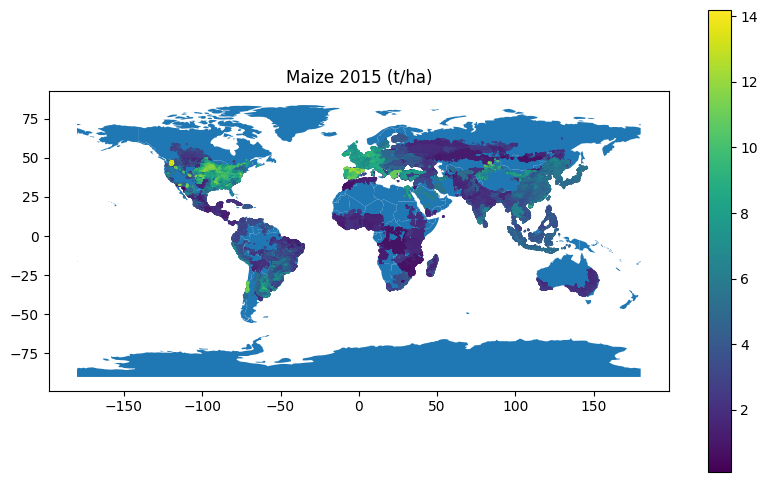

In [58]:
import matplotlib.pyplot as plt
import geopandas as gpd

plt.figure()
gdf = gpd.GeoDataFrame(df[df['year']==datetime(2015, 12, 31)], geometry=gpd.points_from_xy(df[df['year']==datetime(2015, 12, 31)]['lon'], df[df['year']==datetime(2015, 12, 31)]['lat']))   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

gdf.plot(ax=world.plot(figsize=(10, 6)), column=df[df['year']==datetime(2015, 12, 31)]['yield'], markersize=0.2, legend=True)
plt.title(f"Maize 2015 (t/ha)")
plt.show()

In [60]:
df.to_csv("GlobalCropYield5min1982_2015_V4.csv")

In [61]:
df

,lat,lon,yield,year
0,65.333333,-123.416667,NaN,1982-12-31
1,65.333333,-123.333333,NaN,1982-12-31
2,65.333333,-123.250000,NaN,1982-12-31
3,65.333333,-123.166667,NaN,1982-12-31
4,65.333333,-123.083333,NaN,1982-12-31
...,...,...,...,...
3430515,-38.916667,134.333333,NaN,2015-12-31
3430516,-38.916667,134.416667,NaN,2015-12-31
3430517,-38.916667,134.500000,NaN,2015-12-31
3430518,-38.916667,134.583333,NaN,2015-12-31
